in this part, first models will be built and compared on the the z_scaled dataset, which has been cleaned, applied feature selection, and standardized, containing 32 features (excluding fraud label).

then, the best model will be built on the dataset that has been reduced to 5  component (the best and least to explain 95% variance) by pca. The results on two dataset will be compared.

at last, the best model will be applied on the best dataset's out of time (oot) set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           confusion_matrix, classification_report, average_precision_score)
# self-definced functions
from func import optimize_dtypes

# Load dataset

In [2]:
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
print('dataset shape: ', z_scaled.shape)
print('5 sample:')
display(z_scaled.sample(5))
z_scaled = optimize_dtypes(z_scaled)

dataset shape:  (981694, 39)
5 sample:


,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,fulladdress_count_0_by_7,address_count_1,fulladdress_count_1,ssn_dob_count_30,ssn_count_30,...,fulladdress_homephone_count_7,fulladdress_homephone_count_0_by_30,ssn_dob_count_0_by_14,ssn_ssn_count_0_by_30,ssn_firstname_count_0_by_14,ssn_ssn_count_7,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,name_dob_count_0_by_30,fraud_label
829300,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
755604,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
13756,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
449235,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
428785,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0



OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


## split statistics
- 80% train, test set (X, y will be divided by train_test_split function) and
- 20% Out Of Time (OOT) set for validation of the best model

In [3]:
total = z_scaled.shape[0]
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
X_oot = X[round(total*0.8):]
y_oot = y[round(total*0.8):]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Train set loaded: {X_train.shape}")
print(f"Test set loaded: {X_test.shape}")
print(f"OOT set loaded: {X_oot.shape}")
print("check length sum euqals to original length: ",len(y_train)+len(y_test)+len(y_oot)==len(z_scaled.fraud_label))
print(f"Fraud rate in train: {y_train.mean()*100:.2f}%")

Train set loaded: (549748, 38)
Test set loaded: (235607, 38)
OOT set loaded: (196339, 38)
check length sum euqals to original length:  True
Fraud rate in train: 1.46%


In [4]:
del z_scaled

# Build and Compare Baseline Models

traditional svm works really slow for this huge dataset, and from the previous research, it didn't show any better than GBDT, so just skip it here. 
- have not tried replacing it with its approximations, such as LinearSVC and SGDClassifier

In [5]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
}


baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {baseline_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {baseline_results[name]['f1']:.4f}")
    print(f"Training time: {baseline_results[name]['train_time']:.2f} seconds")

# Display baseline results
baseline_df = pd.DataFrame(baseline_results).T
print("\nBaseline Model Comparison:")
print(baseline_df.round(4))


Training Logistic Regression...
ROC-AUC: 0.7647
F1 Score: 0.5517
Training time: 1.23 seconds

Training Decision Tree...
ROC-AUC: 0.7283
F1 Score: 0.5832
Training time: 1.03 seconds

Training Random Forest...
ROC-AUC: 0.7640
F1 Score: 0.5923
Training time: 4.33 seconds

Training Gradient Boosting...
ROC-AUC: 0.7606
F1 Score: 0.6040
Training time: 17.47 seconds

Training Neural Network...
ROC-AUC: 0.7565
F1 Score: 0.6167
Training time: 33.45 seconds

Training XGBoost...
ROC-AUC: 0.7652
F1 Score: 0.6030
Training time: 1.25 seconds

Training LightGBM...
ROC-AUC: 0.7653
F1 Score: 0.6017
Training time: 1.70 seconds

Baseline Model Comparison:
                                                                 model  \
Logistic Regression  LogisticRegression(max_iter=1000, random_state...   
Decision Tree                  DecisionTreeClassifier(random_state=42)   
Random Forest        (DecisionTreeClassifier(max_features='sqrt', r...   
Gradient Boosting    ([DecisionTreeRegressor(criterion='fr

In [6]:
baseline_df.to_csv('Baseline Model Performance.csv')

For Fraud Detection, Recall (aka True Positive Rate or Sensitivity) is crucial that we want to catch as many fraud cases as possible, i.e.the cost of missing a true positive is high. However, it can also increase the risk of false alarms. Thus, to choose the proper models for further training, we have to consider all metrics and prioritize certain metrics over others. After a glance of the above results, GBDT and NN are the two choices for me, just like what we have done in the paper years ago. For future efficiency, let's utilize self-defined function combining multiple metrics with customizable weights.
* and training time may need to be taken into consideration in real situation
$$Recall = \frac{TP}{TP + FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$F1 = 2 \times \frac{Recall \times Precision}{Recall+Precision}$$

In [5]:
baseline_df = pd.read_csv('Baseline Model Performance.csv', index_col=0)
#baseline_df

In [6]:
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }

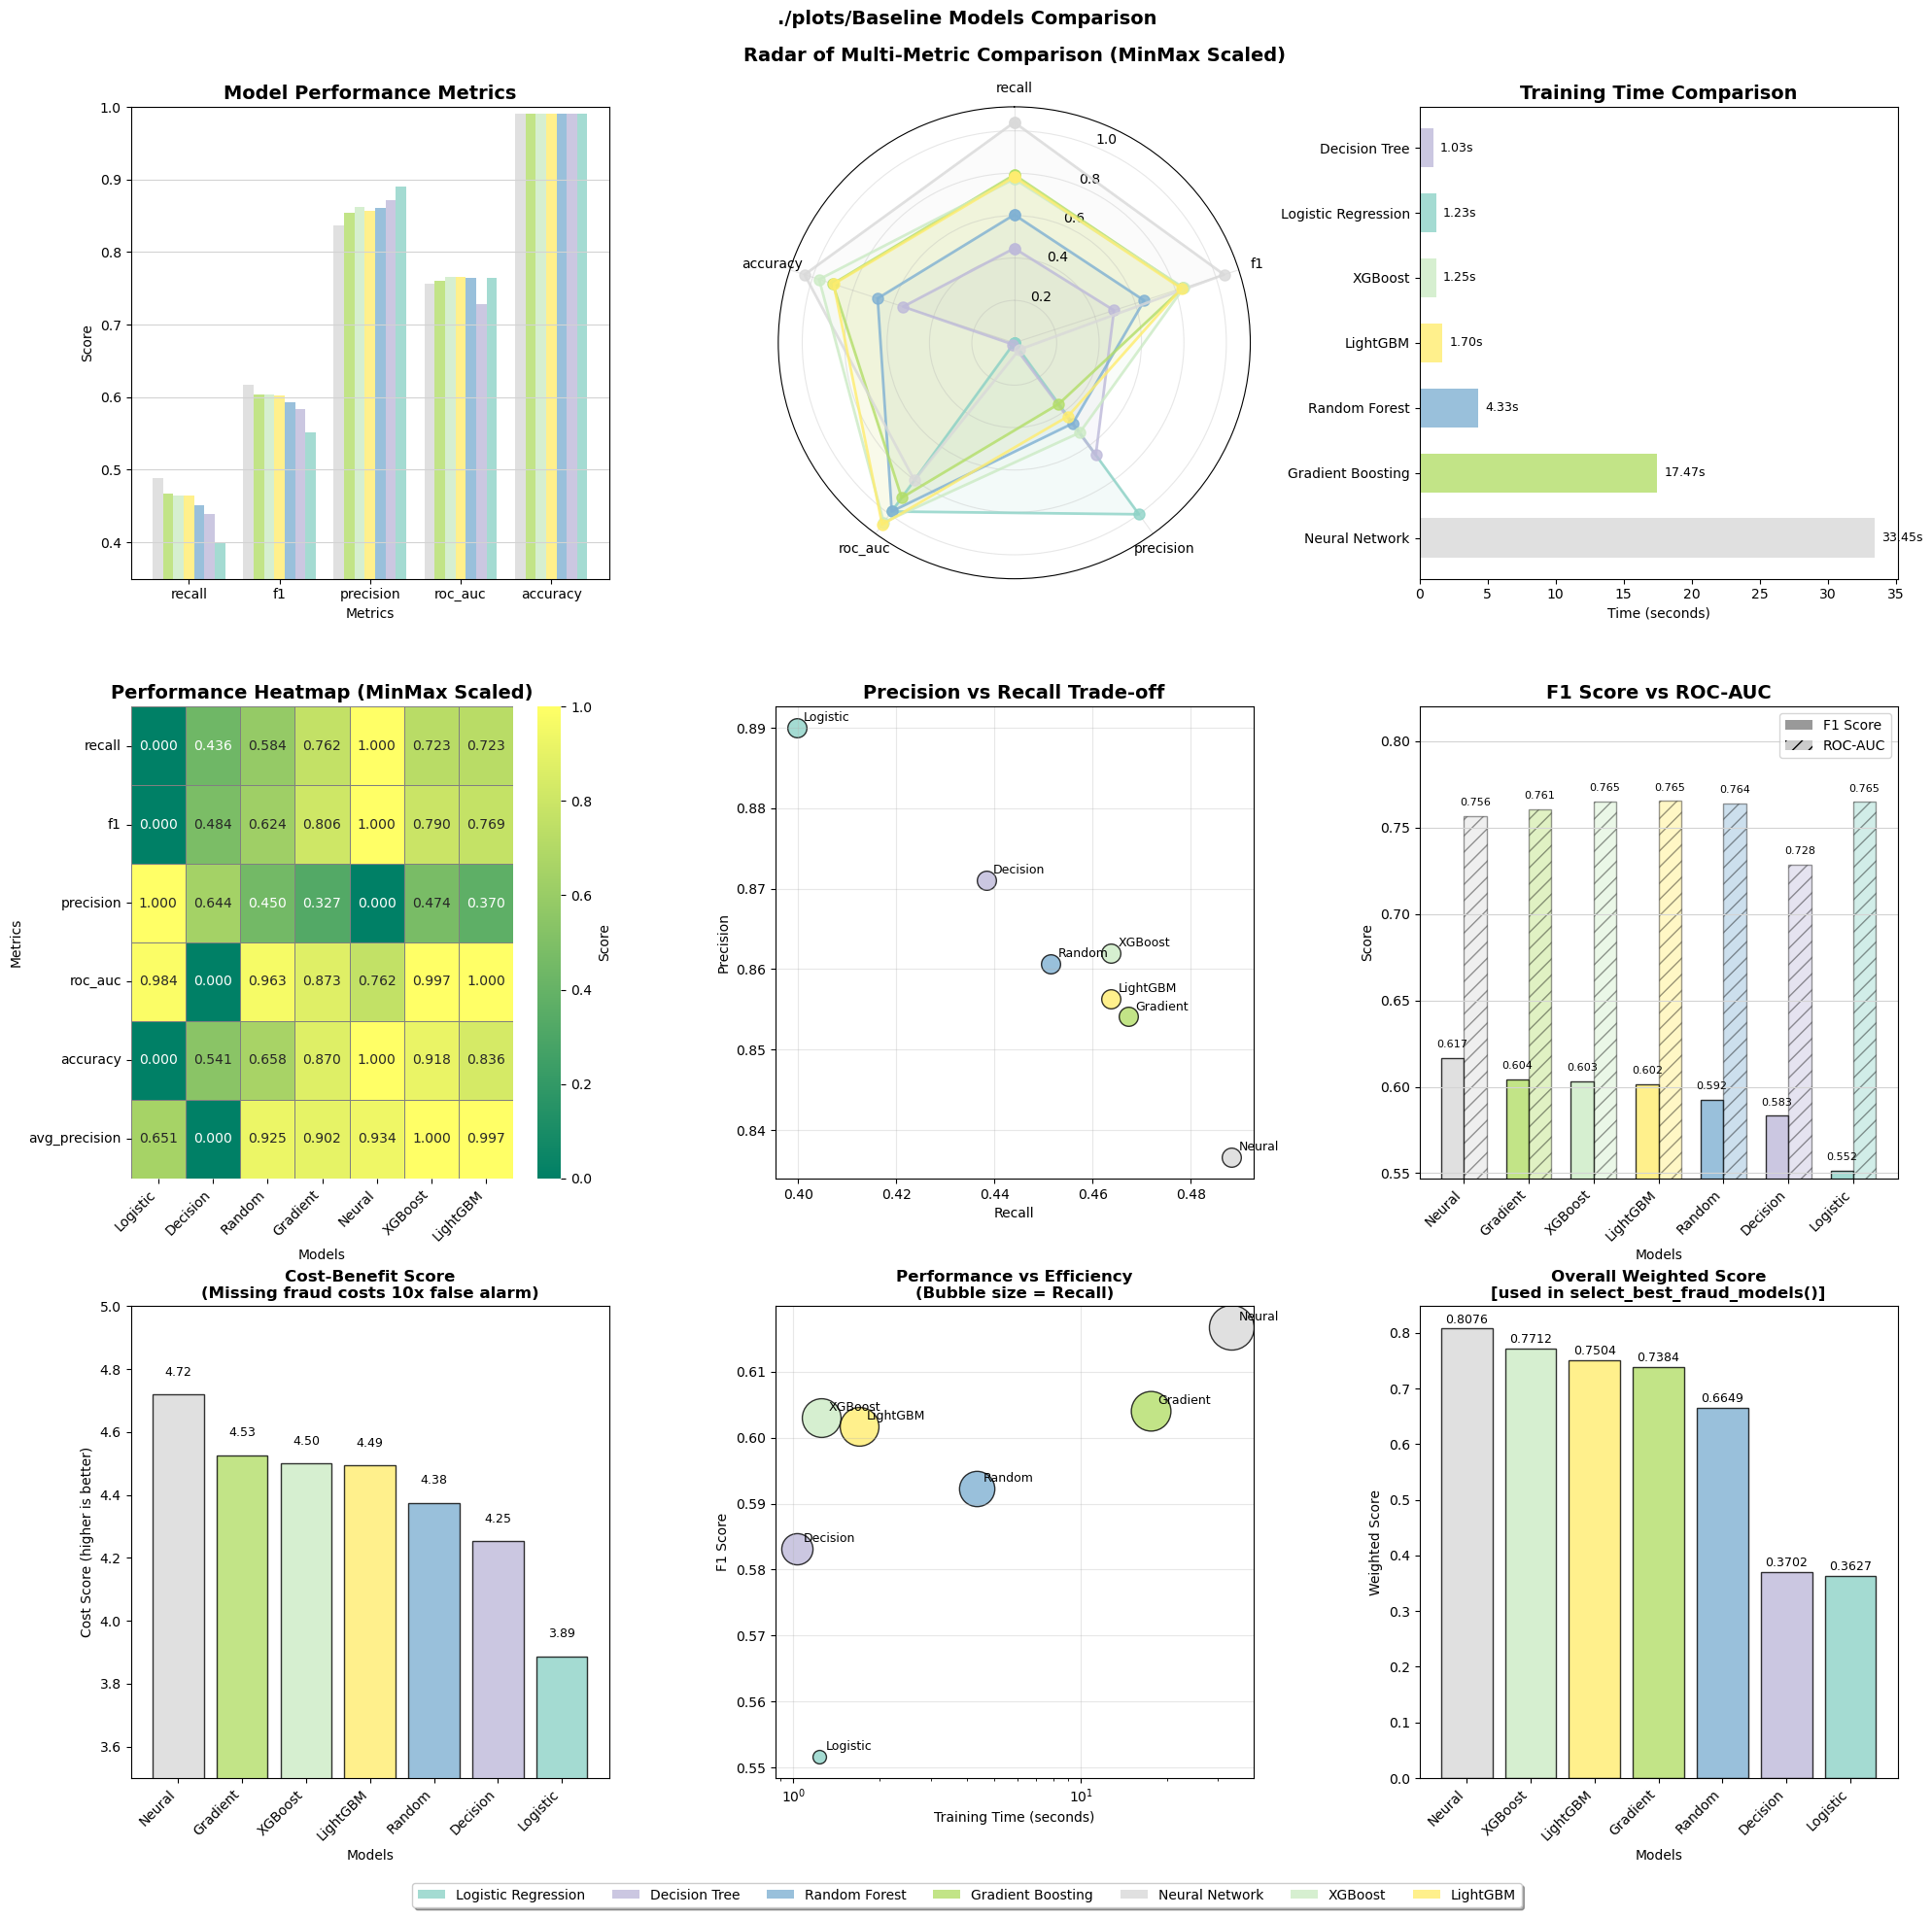

In [7]:
from func import plot_model_comparison
plot_model_comparison(baseline_df, weights = fraud_weights, top_n=3, 
                      figsize=(20, 20), figsave=True, figtitle = './plots/Baseline Models Comparison')

In [8]:
from func import select_best_fraud_models
top_models, weighted_score = select_best_fraud_models(baseline_df, top_n=3, weights=fraud_weights)

In [9]:
top_models

['Neural Network', 'XGBoost', 'LightGBM']

In [10]:
weighted_score

Logistic Regression    0.362708
Decision Tree          0.370180
Random Forest          0.664941
Gradient Boosting      0.738394
Neural Network         0.807627
XGBoost                0.771177
LightGBM               0.750403
Name: weighted_score, dtype: float64

# Hyperparameter Optimization
the top 3 models for optimization are selected based on baseline performance, and I also want to add GBDT

In [11]:
top_models = top_models + ['Gradient Boosting']

skip NN optimization due to large dataset and much time, and for fraud detection, tree models are better anyway

In [12]:
top_models.remove('Neural Network')
top_models

['XGBoost', 'LightGBM', 'Gradient Boosting']

>**a little plug here**, to train faster, if there is cuda GPUS (usually windows OS), can use:
>- XGBClassifier(tree_method='gpu_hist', ...)
>- LGBMClassifier(device='gpu', ...)
>- NN: switch to PyTorch or TensorFlow 
>- SVM: RAPIDS cuML or ThunderSVM  
>from the above, for mac silicon, except NN (tf is recommended than pytorch), others are not supported

optimize_all_models_parallel(..., method='hyperopt' or 'optuna', 'randomized', 
                            n_trials=100,...
                            )

In [15]:
from func_2stageOpt import two_stage_optimize_multiple
optimized_models = two_stage_optimize_multiple(
    X_train, y_train,
    models = top_models,
    n_trials = 150,   # 150 trials per model
    stage1_ratio=0.3,  # 30% for exploration
    show_trial_details=False  # Clean output
)

System Information:
  Platform: Darwin
  Processor: arm
  CPU Cores: 8
  Apple Silicon: True
  Metal Available: True

Optimizing 3 models with 150 trials each
Stage 1: 45 trials, Stage 2: 105 trials
Total trials: 450
Each model will use all 8 CPU cores
Trial details: OFF

Optimizing XGBoost

Two-Stage Optimization for XGBoost
Stage 1: RandomizedSearch with 45 trials (exploration)
Stage 2: Optuna with 105 trials (exploitation)
Total trials: 150
Positive class weight: 67.71

Running Stage 1...
Stage 1 complete! (Time: 1197.4s)
Best F1 Score: 0.6099

Stage 2: Focused search around best parameters

Running Stage 2 optimization...
  Progress: 1% (1/105 trials) - Best: 0.5534 - Time: 10.9s
  Progress: 10% (11/105 trials) - Best: 0.5538 - Time: 211.7s
  Progress: 20% (21/105 trials) - Best: 0.5544 - Time: 410.9s
  Progress: 30% (31/105 trials) - Best: 0.5547 - Time: 612.1s
  Progress: 39% (41/105 trials) - Best: 0.5547 - Time: 829.7s
  Progress: 49% (51/105 trials) - Best: 0.5547 - Time: 1064

In [ ]:
# and less trials for NN
from func_2stageOpt import two_stage_optimization
optimized_NN = two_stage_optimization(
    X_train, y_train,
    model_name='Neural Network',
    stage1_trials=15,  # for exploration
    stage2_trials=30,  # for exploitation
    range_factor=0.5,  # Search ±50% around best values
    verbose=True,
    show_trial_details=False  # Clean output
)

In [19]:
optimized_models

{'XGBoost': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.6238481155990337, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='logloss', feature_types=None,
                gamma=1.5531831263616995, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0030976135766664927,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=3, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=591, n_jobs=-1,
                num_parallel_tree=None, random_state=42, ...),
  'best_params': {'colsample_bytree': 0.6238481155990337,
   'gamma': 1.5531831263616995,
   'learning_rate': 0.0030976135766664927,
   'max_dep

In [24]:
pd.DataFrame(optimized_models).to_csv('Optimized Results.csv')

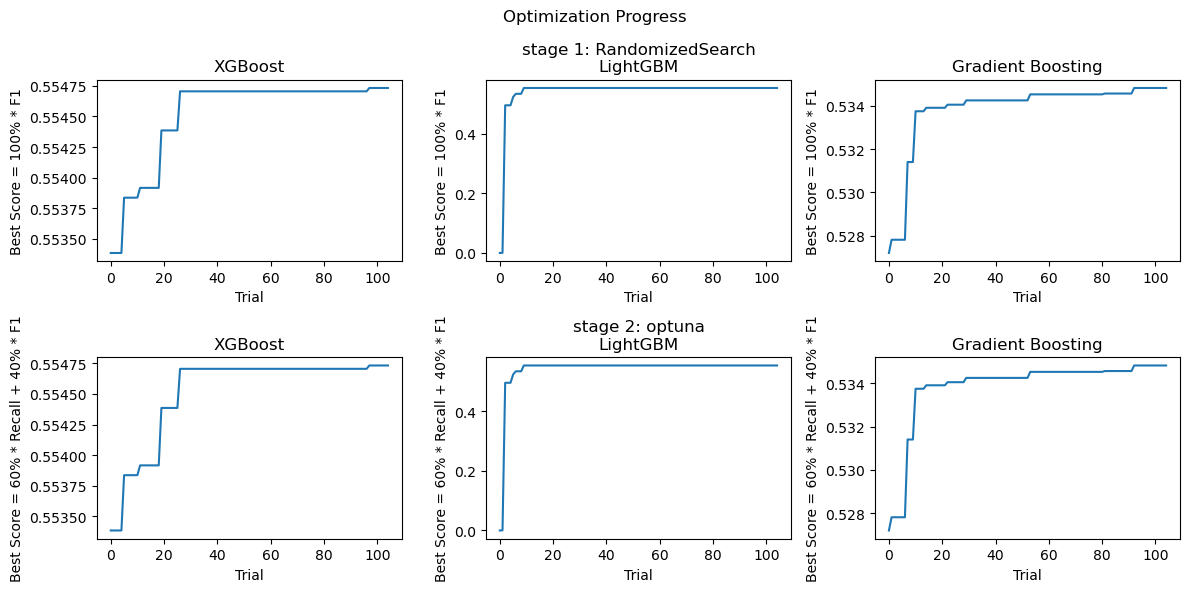

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
i = 0
for name, model in optimized_models.items():
    ax[0, i].plot(model['stage2_history'])
    ax[0, i].set_xlabel('Trial')
    ax[0, i].set_ylabel('Best Score = 100% * F1')
    if i == 1:
        title = f'stage 1: RandomizedSearch\n{name}'
    else:
        title = f'\n{name}'
    ax[0, i].set_title(title)
    
    ax[1, i].plot(model['stage2_history'])
    ax[1, i].set_xlabel('Trial')
    ax[1, i].set_ylabel('Best Score = 60% * Recall + 40% * F1')
    if i == 1:
        title = f'stage 2: optuna\n{name}'
    else:
        title = f'\n{name}'
    ax[1, i].set_title(title)
    i += 1
plt.suptitle('Optimization Progress')
plt.tight_layout()
plt.show()

## Calculate the Optimized Models' Performance with the best parameters

load dataset again if the previous has been deleted

in the result dataset, the models are stored as string in the model row, need to convert them to real model objects to be trained

In [8]:
# optimized_models = pd.read_csv('Top3 Optimized Results.csv', index_col=0)
# optimized_models
# Convert string to actual model objects
# optimized_models = {name: eval(model_str) for name, model_str in dict(optimized_models.loc['model',:]).items()}

In [25]:
optimized_results = {}

for name, model in optimized_models.items():
    model = model['model']
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    optimized_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {optimized_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {optimized_results[name]['f1']:.4f}")
    print(f"Training time: {optimized_results[name]['train_time']:.2f} seconds")

# Display optimized models results
optimized_df = pd.DataFrame(optimized_results).T
print("\nOptimized Model Comparison:")
print(optimized_df.round(4))


Training XGBoost...
ROC-AUC: 0.7708
F1 Score: 0.6181
Training time: 5.33 seconds

Training LightGBM...
ROC-AUC: 0.7702
F1 Score: 0.6166
Training time: 12.13 seconds

Training Gradient Boosting...
ROC-AUC: 0.7702
F1 Score: 0.6191
Training time: 64.94 seconds

Optimized Model Comparison:
                                                               model  \
XGBoost            XGBClassifier(base_score=None, booster=None, c...   
LightGBM           LGBMClassifier(bagging_fraction=0.357144695323...   
Gradient Boosting  ([DecisionTreeRegressor(criterion='friedman_ms...   

                   accuracy precision    recall        f1   roc_auc  \
XGBoost            0.990671  0.751267  0.525089  0.618138  0.770787   
LightGBM           0.990637  0.749789  0.523613  0.616615  0.770164   
Gradient Boosting  0.991397  0.852043  0.486128  0.619057  0.770245   

                  avg_precision train_time  
XGBoost                0.522613    5.32891  
LightGBM               0.479162   12.12569  
Gra

In [26]:
optimized_df.to_csv('Optimized Model Performance.csv')

## Baseline vs Optimized

check how much they have been optimized from their corresponding baseline models, to make sure the optimization is meaningful. Otherwise, run the optimization again with larger trials or try other method, like hyperopt

In [43]:
baseline_df.loc[optimized_df.index, :]

,model,accuracy,precision,recall,f1,roc_auc,avg_precision,train_time
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.991138,0.861957,0.463743,0.603042,0.765199,0.512217,1.253606
LightGBM,"LGBMClassifier(random_state=42, verbosity=-1)",0.991087,0.856371,0.463743,0.601669,0.765316,0.512047,1.696867
Gradient Boosting,GradientBoostingClassifier(random_state=42),0.991108,0.854089,0.467251,0.604045,0.760632,0.505698,17.471276


In [44]:
optimized_df

,model,accuracy,precision,recall,f1,roc_auc,avg_precision,train_time
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.990671,0.751267,0.525089,0.618138,0.770787,0.522613,5.32891
LightGBM,LGBMClassifier(bagging_fraction=0.357144695323...,0.990637,0.749789,0.523613,0.616615,0.770164,0.479162,12.12569
Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.991397,0.852043,0.486128,0.619057,0.770245,0.52467,64.935538


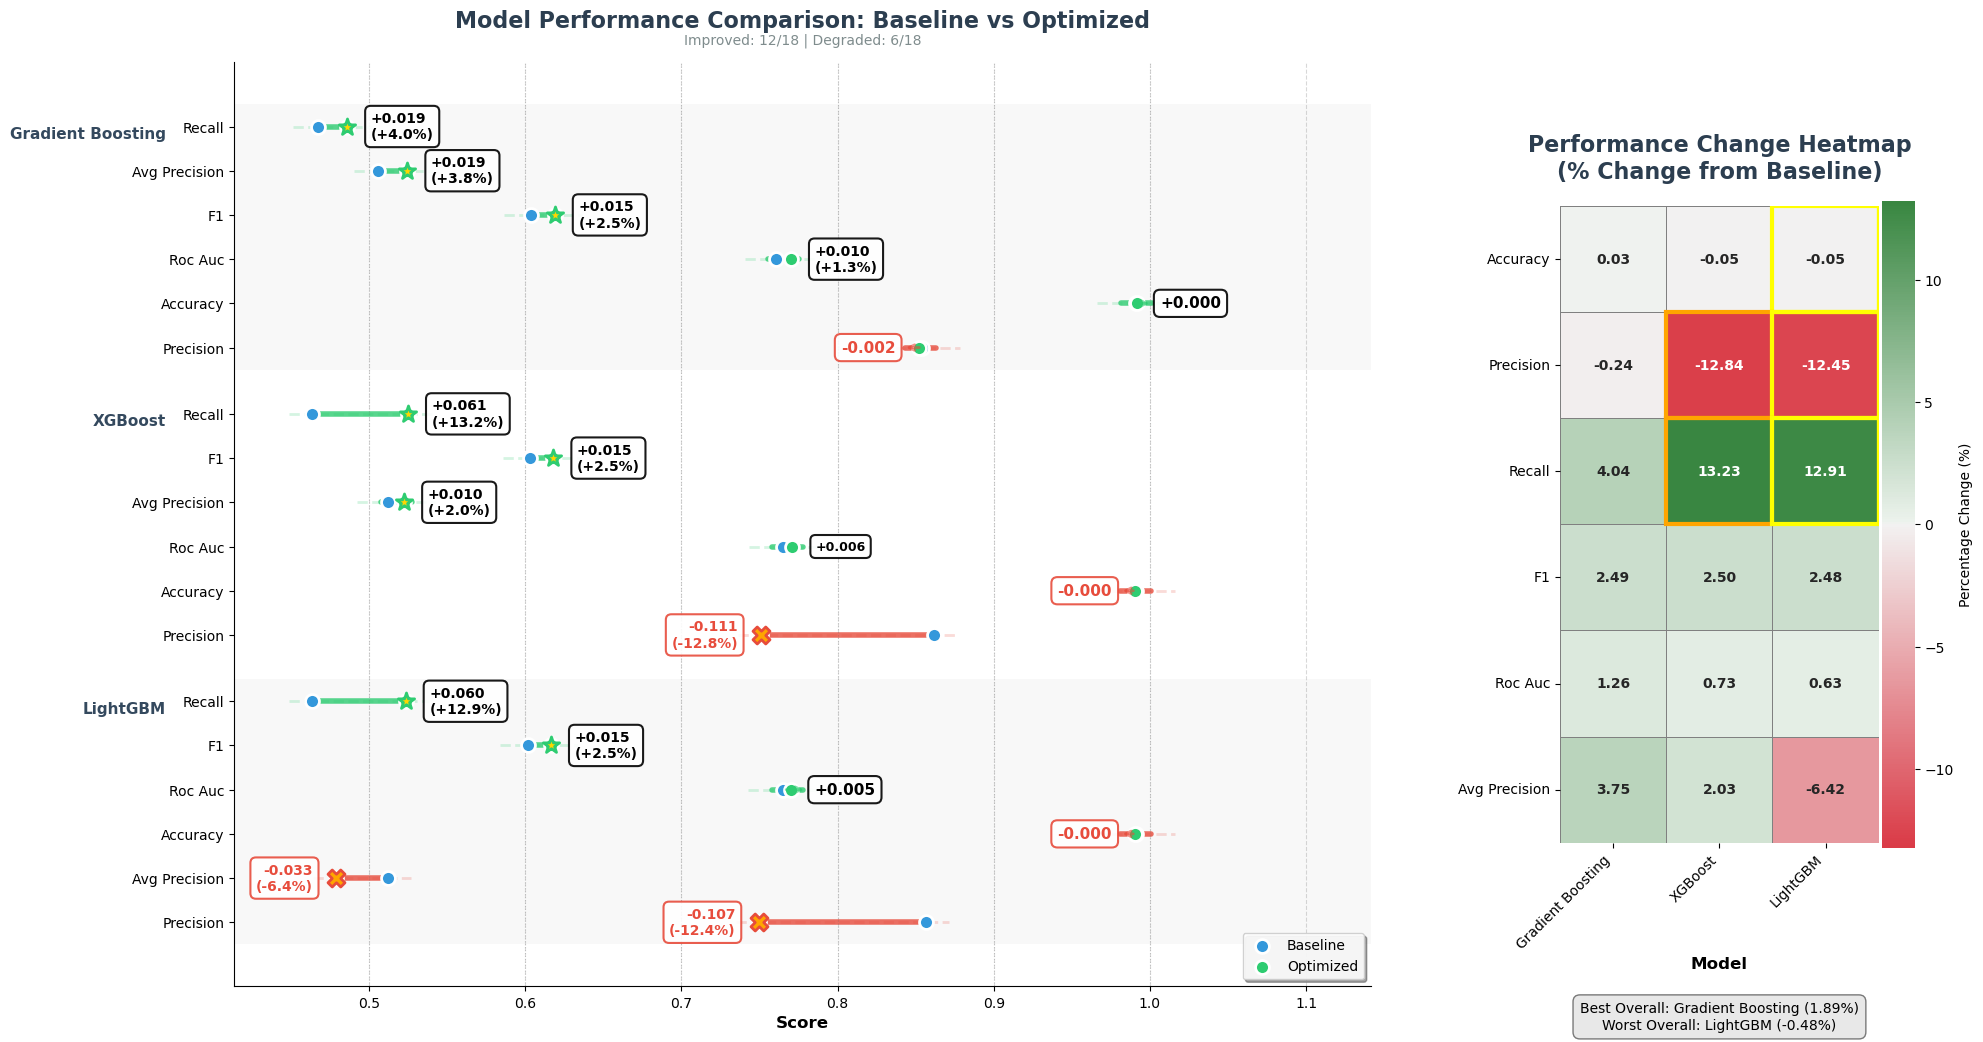


Model Performance Summary:
            Model  Metrics Improved  Metrics Degraded Avg Change Best Improvement        Worst Change
Gradient Boosting                 5                 1      1.89%  recall (+4.04%)  precision (-0.24%)
          XGBoost                 4                 2      0.93% recall (+13.23%) precision (-12.84%)
         LightGBM                 3                 3     -0.48% recall (+12.91%) precision (-12.45%)


In [45]:
from func import compare_performance
baseline_df = pd.read_csv('Baseline Model Performance.csv', index_col=0)
#optimized_df = pd.read_csv('Optimized Model Performance.csv', index_col=0)
compare_performance(baseline_df, optimized_df
                    , save_path = './plots/Optimization Effect.png'
                   )

even the precision decreased for LightGBM and XGB, the recall and a lot scores of them all improved, so just move on to next step

## Compare Optimized Models

again, auto-select the best model, only one for this time

In [46]:
#optimized_df = pd.read_csv('Optimized Model Performance.csv', index_col=0)

In [47]:
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }

In [48]:
from func import select_best_fraud_models
best_model_name, weighted_score = select_best_fraud_models(optimized_df, top_n=1, weights=fraud_weights)

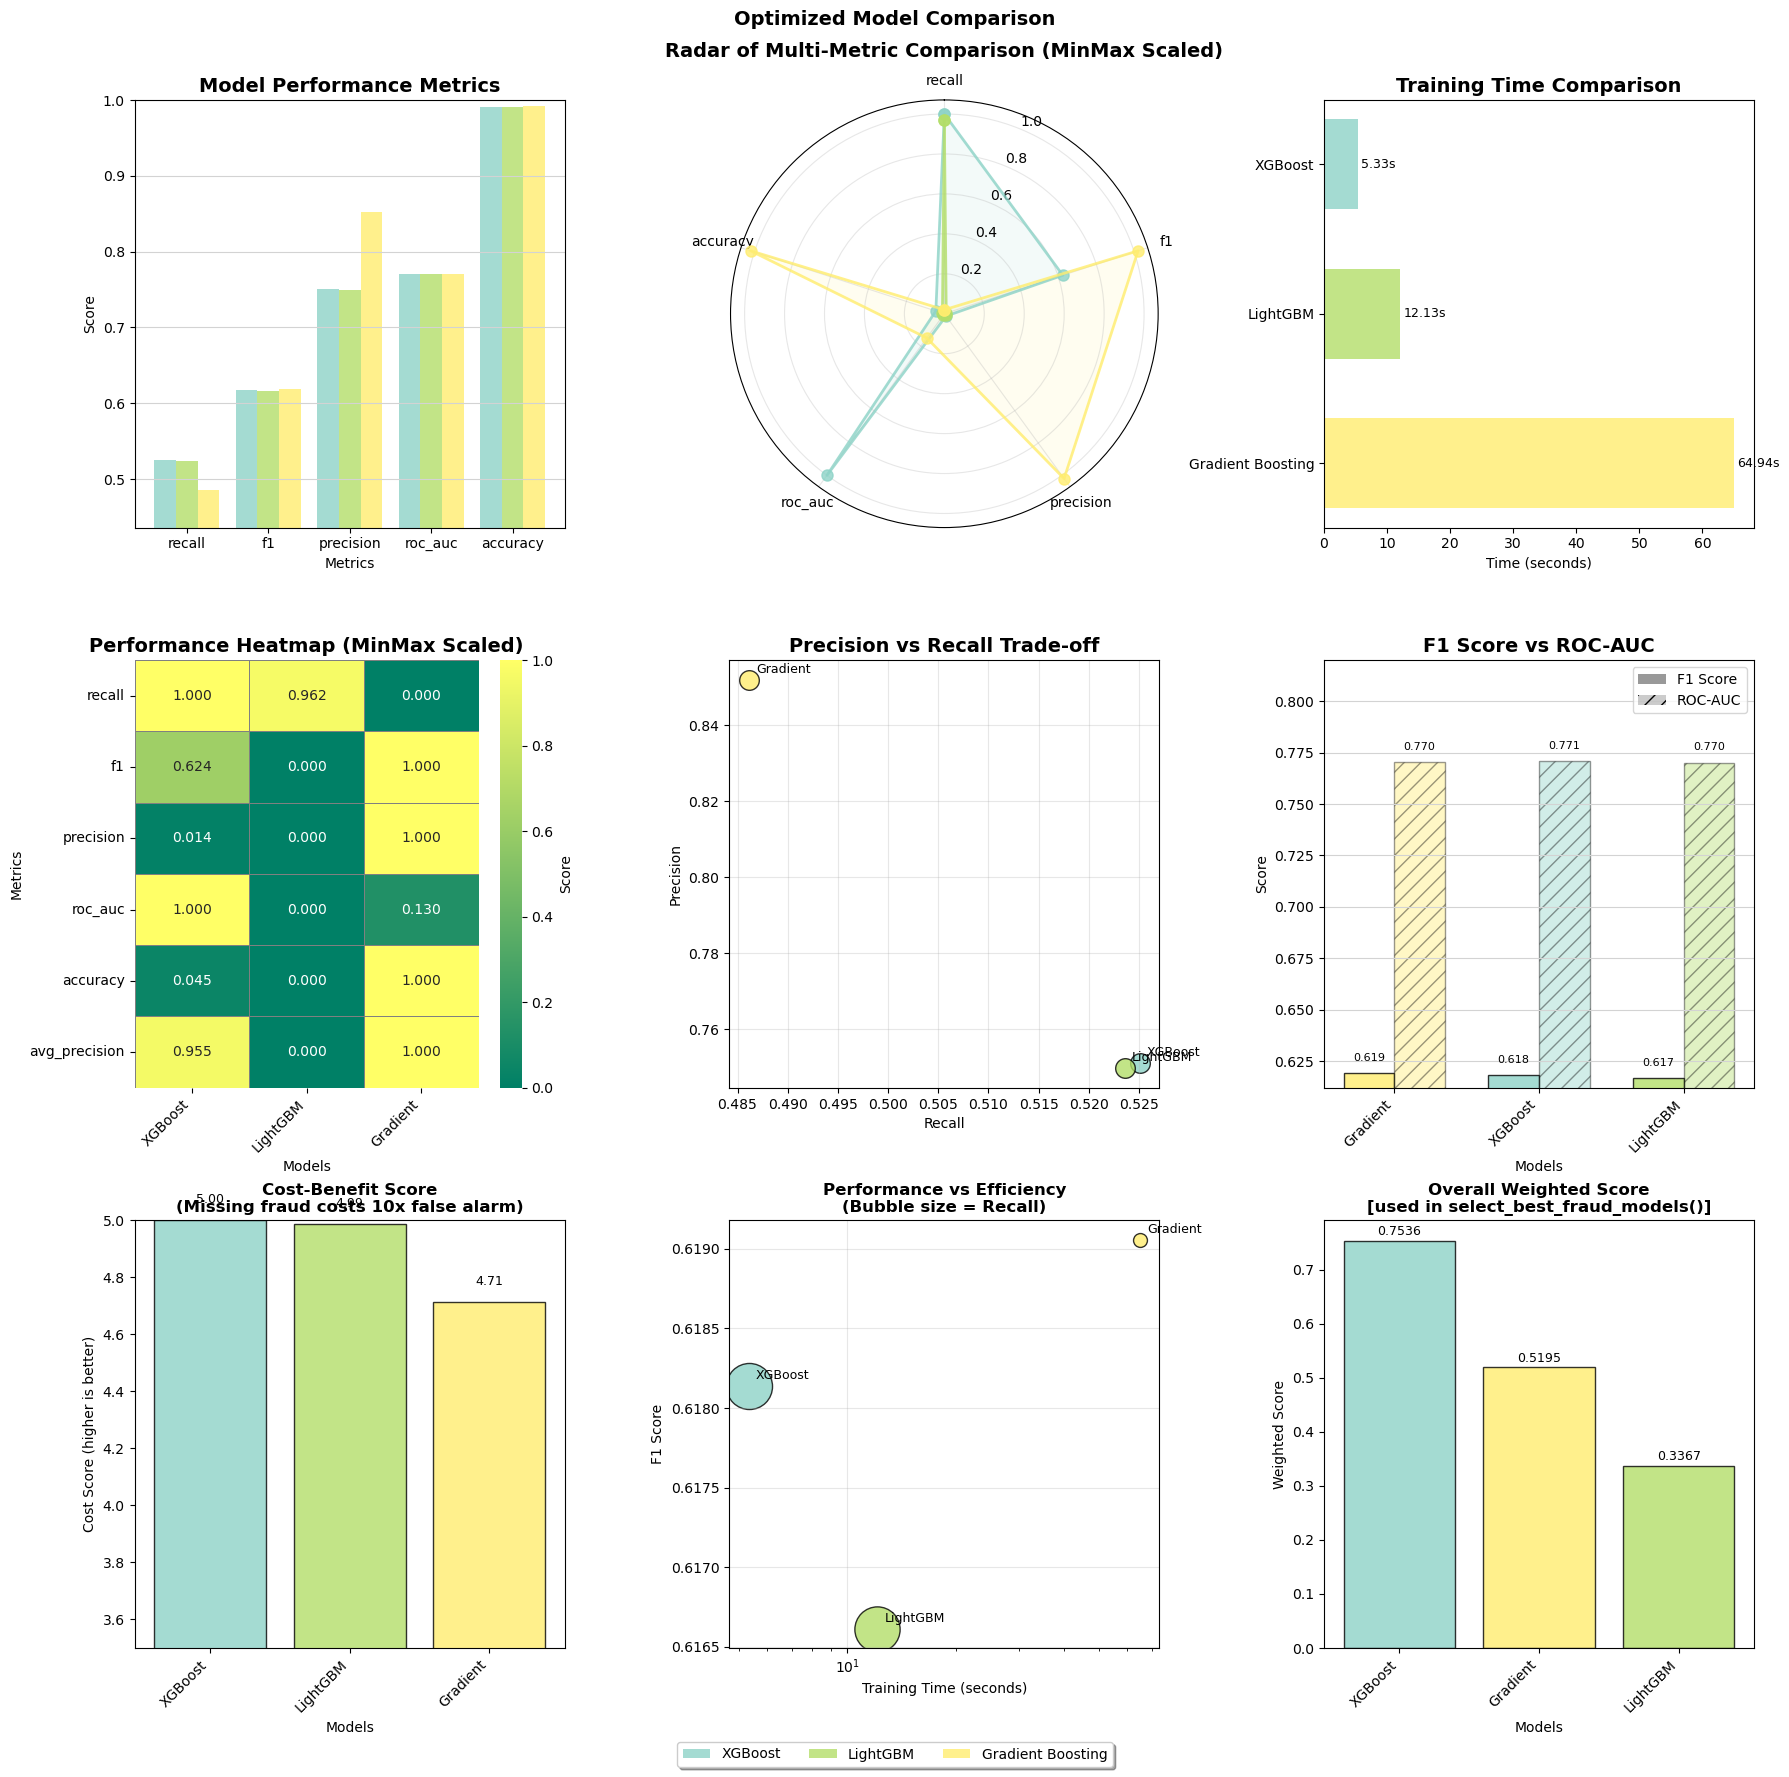

In [49]:
from func import plot_model_comparison
plot_model_comparison(optimized_df, weights = fraud_weights, top_n=1, 
                      figsize=(18, 18), figsave=True, figtitle = 'Optimized Model Comparison')

Overall performance suggest to choose XGBoost

# Final Evaluation

In [53]:
# optimized_models = pd.read_csv('Top3 Optimized Results.csv', index_col=0)
# Convert string to actual model objects if read from csv
# optimized_models = {name: eval(model_str) for name, model_str in dict(optimized_models.loc['model',:]).items()}
best_model = optimized_models[best_model_name[0]]['model']
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6238481155990337, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.5531831263616995, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0030976135766664927,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=591, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [51]:
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
z_scaled = optimize_dtypes(z_scaled)


OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


In [54]:
# Evaluate model
from func import evaluate_model_goodness
goodness_summary, detailed_metrics = evaluate_model_goodness(
    model=best_model, model_name=best_model_name[0],
    whole_dataset = z_scaled, test_size=0.2, 
    top_percent=0.03, niter_max=5,
    display_confusion_matrices=False
)

Evaluating XGBoost performance over 5 iterations...


XGBoost Goodness Summary (Average over 5 iterations):


,train,test,oot
FDR,0.542,0.5352,0.5346
KS,0.5228,0.5174,0.5159
AUC,0.7688,0.7643,0.7611
Thresholds,0.2568,0.2924,0.326
Accuracy,0.9905,0.9905,0.9901
Misclassification,0.0095,0.0095,0.0099
False Positive Rate,0.0026,0.0026,0.0028
True Positive Rate,0.5203,0.5136,0.5143
True Negative Rate,0.9974,0.9974,0.9972
Precision,0.7493,0.7461,0.7352



Key Metrics Stability (Standard Deviation):


,train_std,test_std,oot_std
AUC,0.0005,0.0031,0.0009
KS,0.001,0.0043,0.0002
FDR,0.0013,0.0051,0.0
ACC,0.0001,0.0001,0.0
PRE,0.0049,0.0081,0.0033


Compare with the GBDT model buit years ago: 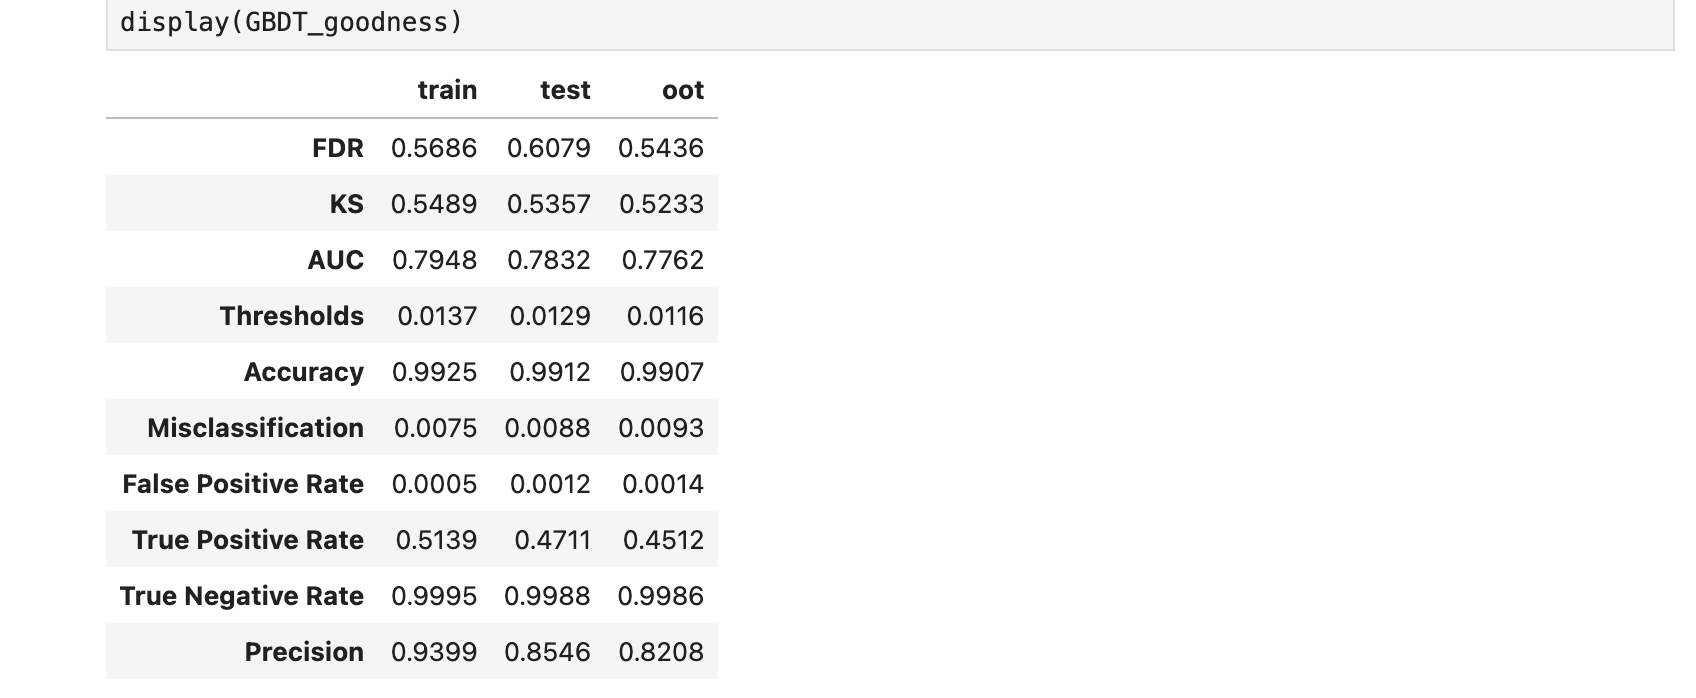

1. Discrimination Ability (AUC)  
* XGBoost shows lower AUC across all sets (train: 0.7688, test: 0.7643, oot: 0.7611)
* GBDT had higher AUC (train: 0.7948, test: 0.7832, oot: 0.7762)
This suggests GBDT has better overall discrimination between fraud and non-fraud cases

2. False Positive Rate - Critical for Fraud Detection  
* XGBoost: Much higher FPR (0.0026-0.0028)
* GBDT: Significantly lower FPR (0.0005-0.0014)
This is concerning - XGBoost flags 2-5x more legitimate transactions as fraudulent

3. Precision Trade-off  
* XGBoost: Lower precision (0.7352-0.7493)
* GBDT: Higher precision (0.8208-0.9399)
GBDT catches proportionally more actual fraud among flagged transactions

4. Model Stability  
* XGBoost shows smaller train-test gaps, suggesting less overfitting
* GBDT shows larger performance drops from train to test/oot sets

**Overall Assessment**  
For fraud detection, GBDT appears superior because:

* Lower false positives - Critical for customer experience (fewer legitimate transactions blocked)
* Higher precision - When it flags fraud, it's more likely to be correct
Better AUC - Overall better at ranking fraud probability

The XGBoost model's higher false positive rate is particularly problematic in fraud detection, where blocking legitimate transactions can damage customer trust and business relationships.

**Recommendation**:  
Unless there are compelling operational reasons (like inference speed or model size), I would recommend sticking with the GBDT model for this fraud detection use case. The significantly lower false positive rate and higher precision make it more suitable for production deployment.

In [55]:
from func import calculate_performance_forms, plot_performance_metrics
forms_dict = calculate_performance_forms(
    model=best_model,
    whole_dataset=z_scaled,
    n_bins=20,
    model_name=best_model_name[0]
)


XGBoost - Data Summary:
Train: 541,747 goods, 8,001 bads, fraud rate: 1.46%
Test:  232,219 goods, 3,388 bads, fraud rate: 1.44%
OOT:   193,445 goods, 2,894 bads, fraud rate: 1.47%


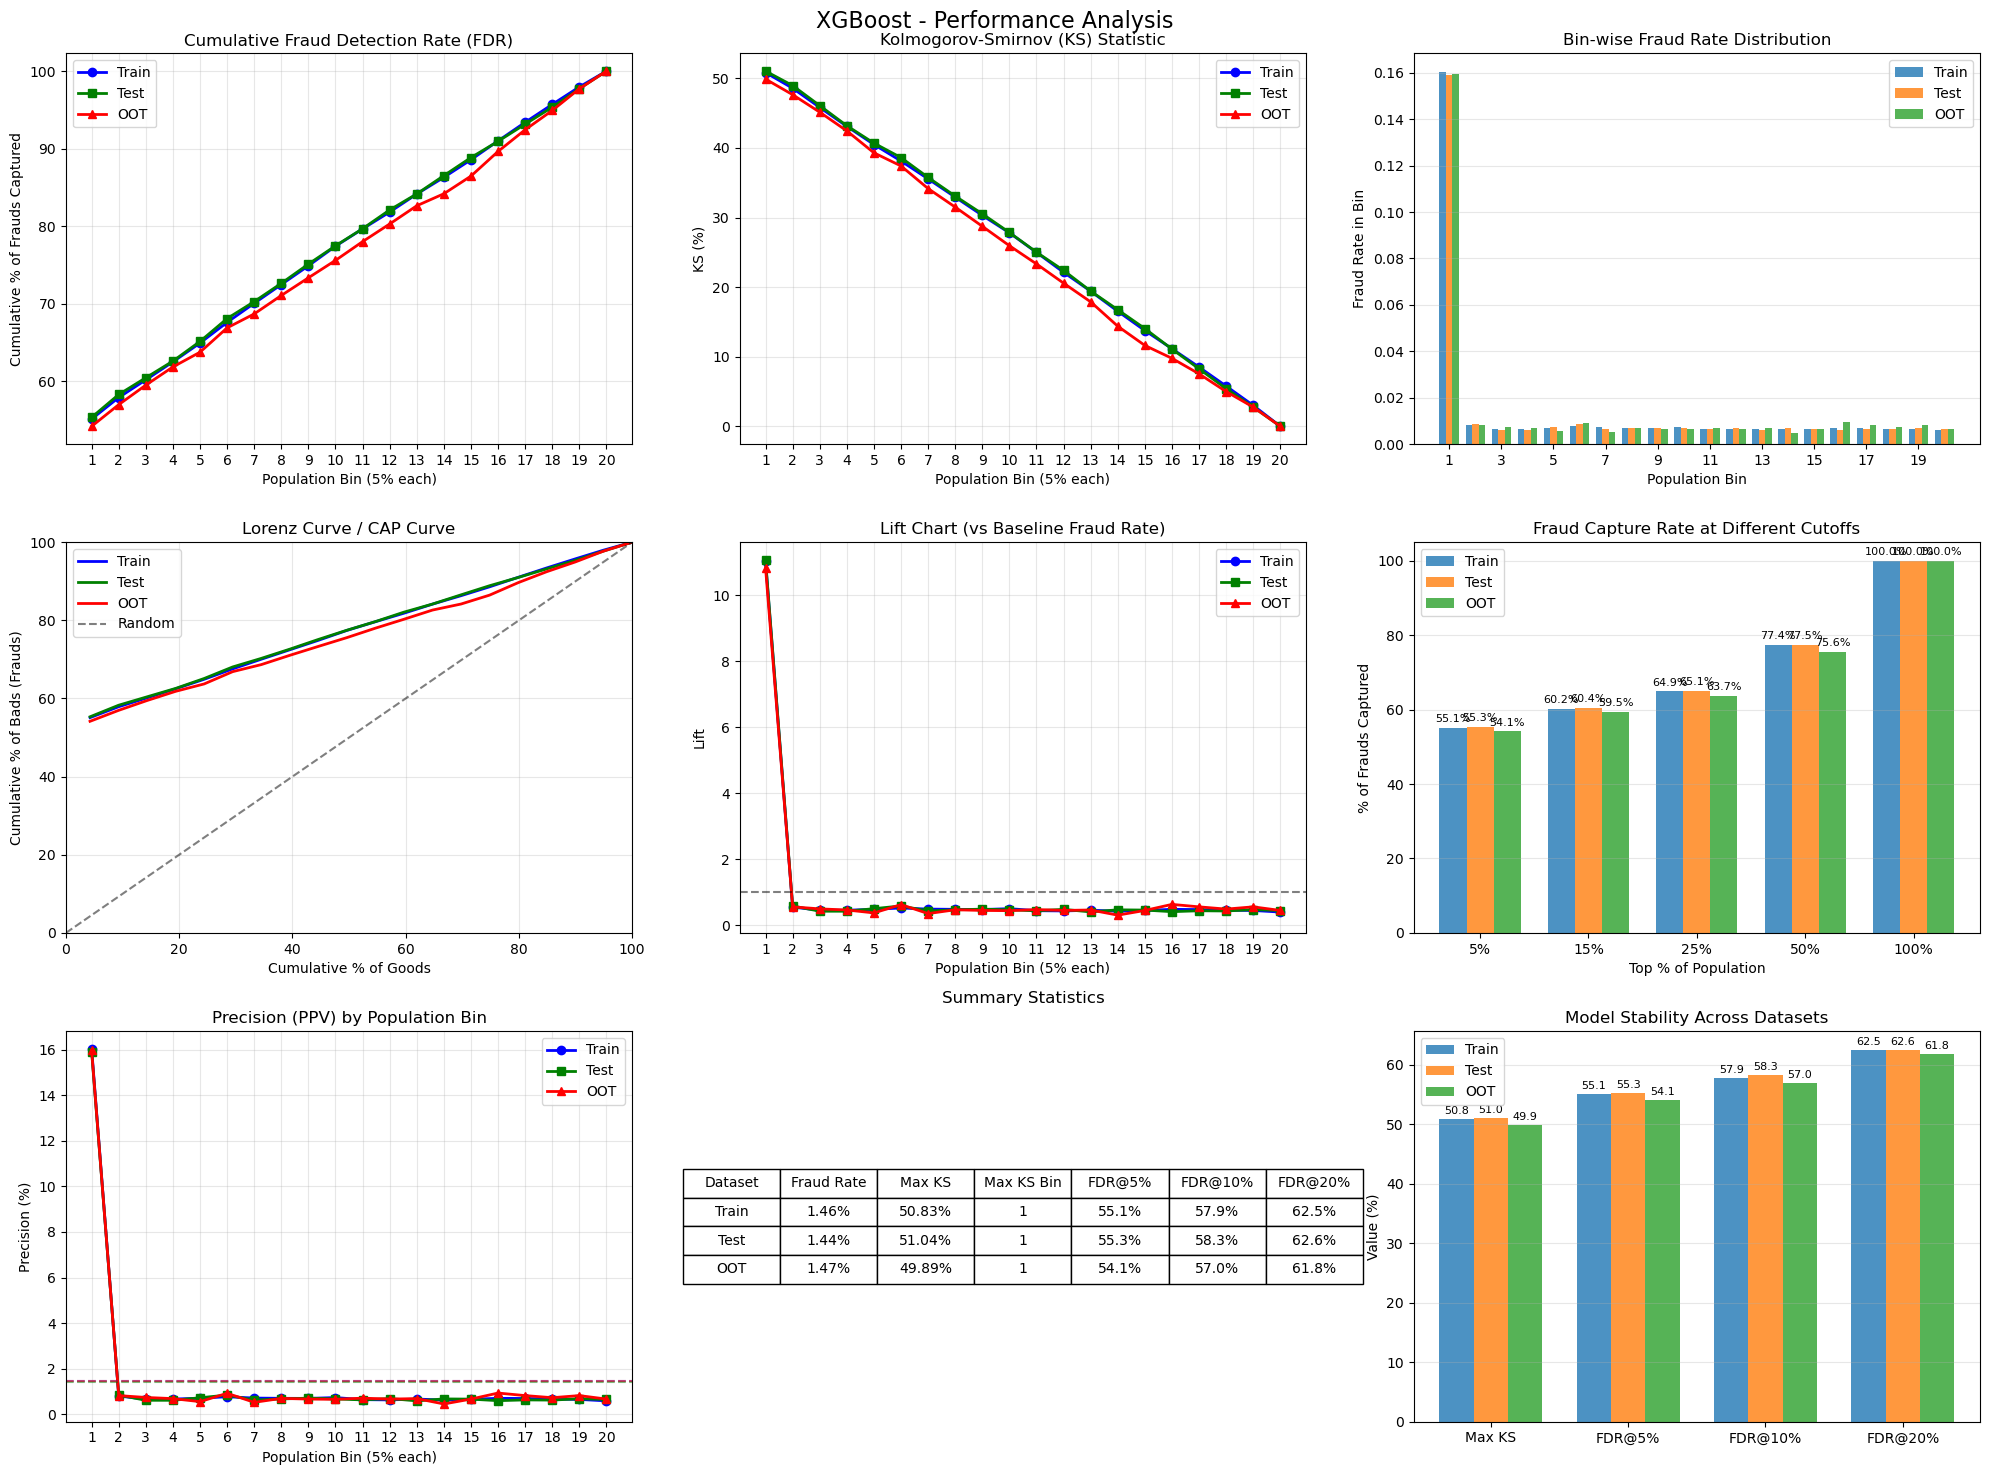


XGBoost - Train Form (Top 5 bins):


,pop_bin,bin_records,bin_goods,bin_bads,bin_%good,bin_%bad,cum_records,cum_goods,cum_bads,cum_%good,cum_%bad_FDR,KS,FPR
0,1,27488,23080,4408,0.8396,0.1604,27488,23080,4408,0.0426,0.5509,50.83,5.24
1,2,27488,27266,222,0.9919,0.0081,54976,50346,4630,0.0929,0.5787,48.58,10.87
2,3,27488,27305,183,0.9933,0.0067,82464,77651,4813,0.1433,0.6015,45.82,16.13
3,4,27488,27303,185,0.9933,0.0067,109952,104954,4998,0.1937,0.6247,43.10,21.00
4,5,27488,27293,195,0.9929,0.0071,137440,132247,5193,0.2441,0.6490,40.49,25.47



XGBoost - Test Form (Top 5 bins):


,pop_bin,bin_records,bin_goods,bin_bads,bin_%good,bin_%bad,cum_records,cum_goods,cum_bads,cum_%good,cum_%bad_FDR,KS,FPR
0,1,11781,9907,1874,0.8409,0.1591,11781,9907,1874,0.0427,0.5531,51.04,5.29
1,2,11781,11681,100,0.9915,0.0085,23562,21588,1974,0.0930,0.5826,48.96,10.94
2,3,11781,11708,73,0.9938,0.0062,35343,33296,2047,0.1434,0.6042,46.08,16.27
3,4,11781,11708,73,0.9938,0.0062,47124,45004,2120,0.1938,0.6257,43.19,21.23
4,5,11781,11695,86,0.9927,0.0073,58905,56699,2206,0.2442,0.6511,40.69,25.70



XGBoost - OOT Form (Top 5 bins):


,pop_bin,bin_records,bin_goods,bin_bads,bin_%good,bin_%bad,cum_records,cum_goods,cum_bads,cum_%good,cum_%bad_FDR,KS,FPR
0,1,9817,8250,1567,0.8404,0.1596,9817,8250,1567,0.0426,0.5415,49.89,5.26
1,2,9817,9736,81,0.9917,0.0083,19634,17986,1648,0.0930,0.5695,47.65,10.91
2,3,9817,9744,73,0.9926,0.0074,29451,27730,1721,0.1433,0.5947,45.14,16.11
3,4,9817,9749,68,0.9931,0.0069,39268,37479,1789,0.1937,0.6182,42.45,20.95
4,5,9817,9762,55,0.9944,0.0056,49085,47241,1844,0.2442,0.6372,39.30,25.62


In [56]:
plot_performance_metrics(forms_dict, model_name=best_model_name[0])

In [ ]:
# train_form = forms_dict['train_form']
# test_form = forms_dict['test_form']
# oot_form = forms_dict['oot_form']